In [1]:
import json


import numpy as np
import pickle
from PIL import Image
from scipy.misc import imread, imresize
from collections import Counter
from sklearn.neighbors import NearestNeighbors
import time 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
import urllib.request
import shutil
from random import shuffle

from data.VGG16 import vgg16
from data.VGG16.imagenet_classes import class_names
import tensorflow as tf

import vist

from wordcloud import WordCloud
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)


In [43]:
with open("data/img2probs", 'rb') as file:
        img2probs = pickle.load(file)

In [ ]:
with open("data/img2features", 'rb') as file:
        img2features = pickle.load(file)

print(len(img2features)) 
print(len(list(img2features.values())[0]))

In [ ]:
with open("data/image2dii", 'rb') as file:
        image2dii = pickle.load(file)

# Import annotations

In [ ]:

dii = json.load(open('data/dii/val.description-in-isolation.json', 'r'))

In [ ]:
print(dii['type'])
print(dii['info'])

print("Fields:")
for key in dii.keys():
    print('', key, type(dii[key]))
    

albums = dii['albums'] 
annotations = dii['annotations'] 
images = dii['images'] 


print()
print(len(albums))
    
print("Album Fields:")
for subkey in albums[0].keys():
    print(' %s: %s' % (subkey,albums[0][subkey]))
    
print()
print(len(annotations))    
print("Annotation[0] Fields:")
for subkey in annotations[0][0].keys():
    print(' %s: %s' % (subkey,annotations[0][0][subkey]))
    
print()
print(len(images))
print("Image Fields:")
for subkey in images[7].keys():
    print(' %s: %s' % (subkey,images[0][subkey]))

In [5]:
im2texts = {}
for ann in annotations:
    ann = ann[0]
    im_id = ann["photo_flickr_id"]
    text  = ann["text"]
    
    if not im_id in im2texts:
        im2texts[im_id] = [text]
    else:
        im2texts[im_id].append(text)
#     if len(ann) != 1:
#         print(len(ann))

print(len(im2texts))
# for im_id in im2texts:
#     if len(im2texts[im_id]) != 1:
#         print(len(im2texts[im_id]))

# print(im2texts['392254079'])
# print(im2texts.keys())

4990


# Initialize SIS

In [18]:
vist_images_dir = 'data/val.images'
vist_annotations_dir = 'data'
sis = vist.Story_in_Sequence(vist_images_dir, vist_annotations_dir, ['val'])
dii = vist.Description_in_Isolation(vist_images_dir, vist_annotations_dir, ['val'])

sis's [val] loaded. It took 0.28 seconds.
Make mapping ...
Mapping for [Albums][Images][Stories][Sents] done.
dii's [val] loaded. It took 0.32 seconds.
Make mapping ...
Mapping for [Albums][Images][Sents] done.


### initialize topics

In [13]:
topic2albums = {} 

for album in sis.Albums.values():
    album_id = album['id']
    vist_label = album["vist_label"]
    
    if not vist_label in topic2albums: 
        topic2albums[vist_label] = [album_id]
    else: 
        topic2albums[vist_label].append(album_id)
        
        
topic2stories = {}

for topic in topic2albums:
    topic2stories[topic] = []
    
    topic_albums = topic2albums[topic];
    for album_id in topic_albums:
        stories = sis.Albums[album_id]['story_ids']
        topic2stories[topic].extend(stories)
        
    

print("Topics (#albums) (#stories)")
for i,key in enumerate(sorted(topic2albums.keys())):         
    print("%d.%s (%d)(%d)"%(i,key, len(topic2albums[key]), len(topic2stories[key])))


sis.Topics = Topics = {topic : {'story_ids' : topic2stories[topic], 'album_ids' : topic2albums[topic]} for topic in topic2stories}


Topics (#albums) (#stories)
0.4th_of_july (44)(220)
1.MISC (60)(300)
2.amusement_park (103)(515)
3.award_ceremony (16)(80)
4.baby_shower (5)(25)
5.bar_mitzvah (8)(40)
6.bat_mitzvah (2)(10)
7.beach (150)(750)
8.bike_race (29)(145)
9.birthday (87)(435)
10.birthday_party (20)(100)
11.breaking_up (77)(385)
12.building_a_house (98)(490)
13.camping (1)(5)
14.car_accident (26)(130)
15.carnival (57)(285)
16.christmas (20)(100)
17.church (47)(235)
18.cinco_de_mayo (20)(100)
19.cooking_dinner (19)(95)
20.day_parade (23)(115)
21.easter (50)(250)
22.eid_al-adha (2)(10)
23.eid_al-fitr (3)(15)
24.engagement (17)(85)
25.fair (14)(70)


## HTML GENERATION

In [31]:


num_of_stories = 2
shuffle_stories = True

    
content = ""    

content +="Topics(#stories): <ol>"
for i,key in enumerate(topic2stories.keys()):         
    content += '<li> <a href="#%s"> %s (%d) </a> </li>'%(key,key, len(topic2stories[key]))

content +="</ol>"
td_width = 50

c = 0
for topic in sis.Topics:
    if c > 5:
        pass #break
    c += 1   
    
    story_ids = sis.Topics[topic]["story_ids"]
    if shuffle_stories:
        shuffle(story_ids)
        
    story_ids = story_ids[:num_of_stories] 
    
    #topic
    content += '<h2  id="%s">%s</h2>\n' % (topic,topic) 
    
    
    print ('Topic : ', topic)
    for story_id in story_ids:
        
        #story id
        content += '<h3> Story id: %s </h3>\n' % story_id
        
        content += '<table cellspacing="15"><tbody>'

        tr = '<tr>'
        #image 
        for img_id in sis.Stories[story_id]['img_ids']:
            filename = "data/val.images/" + img_id + ".jpg"
            td = '<td  width="%d"><img src="%s" align="middle"  /></td>'%(td_width,filename)
            tr += td
        content += tr + "\n"
        
        tr = "<tr>"
        #sis text
        for sent_id in  sis.Stories[story_id]['sent_ids']:
            sis_text = sis.Sents[sent_id]['text']
            td = '<td  width="%d"><b>SIS: </b> %s</td>' %(td_width, sis_text)
            tr += td
        content += tr + "\n"
        
        tr = "<tr>"
        #dii text
        for img_id in sis.Stories[story_id]['img_ids']: 
            image_dii = image2dii[img_id][0]
            td = '<td  width="%d"><b>DII: </b> %s </td>' % (td_width, image_dii)
            tr += td
        content += tr + "\n"
        
        tr = "<tr>"
        #tags
        for img_id in sis.Stories[story_id]['img_ids']:  
            
            image_tags = image2dii[img_id][1]
            td = '<td  width="%d"><b>Tags: </b> %s</td>' % (td_width,image_tags.replace(" ", ", "))
            tr += td
        content += tr + "\n"
        
    
        content += "</tbody></table>\n"
    
# print(content)

Topic :  birthday
Topic :  fair
Topic :  baby_shower
Topic :  christmas
Topic :  4th_of_july
Topic :  carnival
Topic :  day_parade
Topic :  bat_mitzvah
Topic :  breaking_up
Topic :  bike_race
Topic :  award_ceremony
Topic :  bar_mitzvah
Topic :  engagement
Topic :  camping
Topic :  eid_al-fitr
Topic :  cooking_dinner
Topic :  cinco_de_mayo
Topic :  church
Topic :  MISC
Topic :  car_accident
Topic :  beach
Topic :  amusement_park
Topic :  birthday_party
Topic :  building_a_house
Topic :  easter
Topic :  eid_al-adha


In [32]:

prefix = """<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <title>Image list prediction</title>
  <style type="text/css">
   img {
     width:200px;
   }
  </style>
  </head>
  <body>

<h1>Visual Story Cloze Test</h1>
<h2>Athanasios Efthymiou, Athanasios Roidis, Georgios Sidiropoulos</h2>""""

postfix = """</body> </html>"""
 
      
with open('stories.html', 'wb') as html_file:
    html_file.write( prefix + content.encode("utf-8") + postfix)

# VGG16

### Load VGG16

In [54]:
sess = tf.Session()
imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
vgg = vgg16.vgg16(imgs, 'data/VGG16/vgg16_weights.npz', sess)

0 conv1_1_W (3, 3, 3, 64)
1 conv1_1_b (64,)
2 conv1_2_W (3, 3, 64, 64)
3 conv1_2_b (64,)
4 conv2_1_W (3, 3, 64, 128)
5 conv2_1_b (128,)
6 conv2_2_W (3, 3, 128, 128)
7 conv2_2_b (128,)
8 conv3_1_W (3, 3, 128, 256)
9 conv3_1_b (256,)
10 conv3_2_W (3, 3, 256, 256)
11 conv3_2_b (256,)
12 conv3_3_W (3, 3, 256, 256)
13 conv3_3_b (256,)
14 conv4_1_W (3, 3, 256, 512)
15 conv4_1_b (512,)
16 conv4_2_W (3, 3, 512, 512)
17 conv4_2_b (512,)
18 conv4_3_W (3, 3, 512, 512)
19 conv4_3_b (512,)
20 conv5_1_W (3, 3, 512, 512)
21 conv5_1_b (512,)
22 conv5_2_W (3, 3, 512, 512)
23 conv5_2_b (512,)
24 conv5_3_W (3, 3, 512, 512)
25 conv5_3_b (512,)
26 fc6_W (25088, 4096)
27 fc6_b (4096,)
28 fc7_W (4096, 4096)
29 fc7_b (4096,)
30 fc8_W (4096, 1000)
31 fc8_b (1000,)


### Extract fc7 and fc8 features from caltech101

In [ ]:
# verall_start = time.time()
# caltech_features = {}
c_counter = 0
for class_folder in os.listdir("./data/101_ObjectCategories/"):
    c_counter+=1
    
    # error check (if already loaded)
    if class_folder in caltech_features:
        img_names = os.listdir("./data/101_ObjectCategories/" + class_folder)
        if(len(img_names) == len(caltech_features[class_folder])):
            print("%d.%s is already loaded!" % (c_counter,class_folder))
            continue
        
    caltech_features[class_folder] = {}
    img_names = os.listdir("./data/101_ObjectCategories/" + class_folder)
    counter = 0
    start = time.time()
    for img_name in img_names:
        caltech_features[class_folder][img_name] = {}
        
        img = imread("./data/101_ObjectCategories/" + class_folder + "/" + img_name)
        img = imresize(img, (224, 224))
        
        #if grayscale, convert to RGB
        if len(img.shape) == 2:
            tmp = np.empty((224,224,3), dtype = img.dtype)
            tmp[:,:,0] = img
            tmp[:,:,1] = img
            tmp[:,:,2] = img
            img = tmp
            
        
        
        fc7 = sess.run(vgg.fc2, feed_dict={vgg.imgs: [img]})[0]
        fc8 = sess.run(vgg.fc3l, feed_dict={vgg.fc2: [fc7]})[0] 
        
        
        caltech_features[class_folder][img_name]["fc7"] = fc7
        caltech_features[class_folder][img_name]["fc8"] = fc8
        counter += 1
        print("\r%d.%s %d %%" % (c_counter, class_folder, 100 * counter / len(img_names)), end ='')
    
    print("\r%d.%s finished! (%d secs)" %(c_counter, class_folder, time.time() - start))
    with open("data/caltech_features", "wb") as output_file:
        pickle.dump(caltech_features, output_file)
        
print("Total time: %d secs" % (time.time() - verall_start))        
        

Probs:
  canoe 0.586767
  gondola 0.34725
  paddle, boat paddle 0.0575604
  lakeside, lakeshore 0.00171235
  lifeboat 0.00114182
  yawl 0.000628677
  speedboat 0.000537968
  cello, violoncello 0.00043944
  boathouse 0.000352987
  breakwater, groin, groyne, mole, bulwark, seawall, jetty 0.000300964


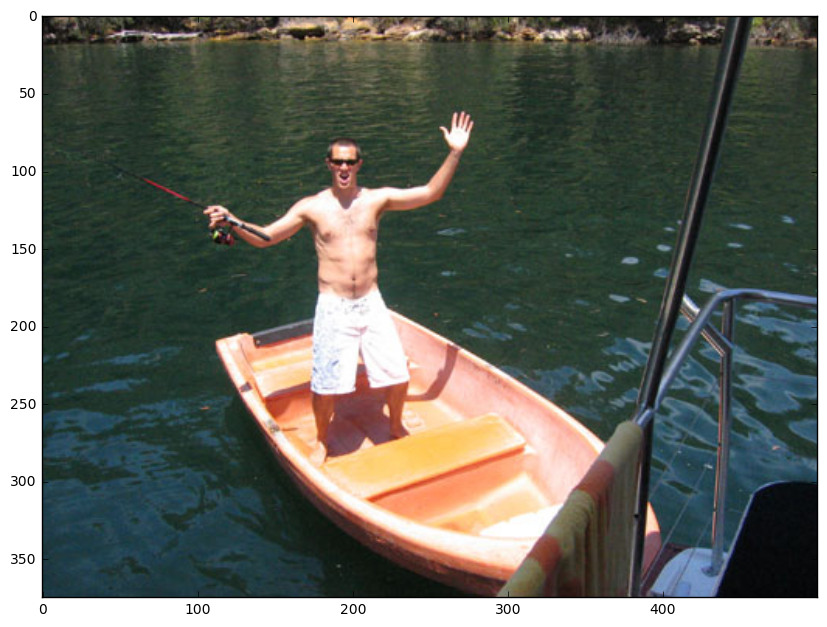

In [55]:
# Test class prediction of vgg
img1 = imread('data/val.images/1751489.jpg', mode='RGB')
plt.imshow(img1)

img1 = imresize(img1, (224, 224))
prob = sess.run(vgg.probs, feed_dict={vgg.imgs: [img1]})[0]
preds = (np.argsort(prob)[::-1])[0:10]
print("Probs:")
for p in preds:
    print(" ",class_names[p], prob[p])
# print(prob) 


1751489.jpg
Probs:
  canoe 0.586768
  gondola 0.347251
  paddle, boat paddle 0.0575605
  lakeside, lakeshore 0.00171236
  lifeboat 0.00114182


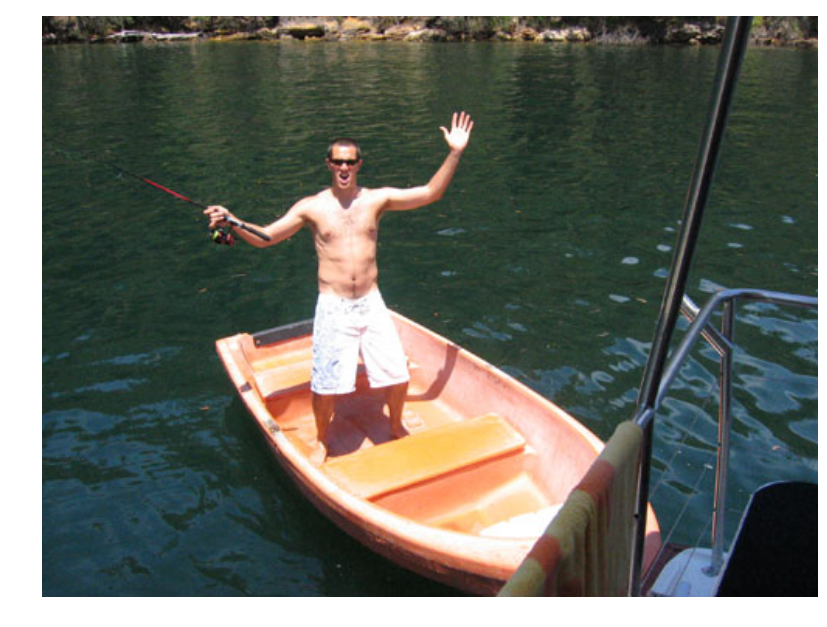

In [56]:
#test probabilities of img2probs work correctly
random_im = "1751489.jpg"#random_im = list(img2probs.keys())[np.random.randint(len(img2probs))]
print(random_im)
img = imread("data/val.images/" + random_im)
plt.imshow(img)
plt.axis("off")

top_k = 5

prob = img2probs[random_im]
preds = (np.argsort(prob)[::-1])[0:top_k]

print("Probs:")
for p in preds:
    print(" ",class_names[p], prob[p]) 
# print(prob)


## Knn search

In [ ]:
image_features = []

im_ids = []

for im_id in img2features:
    image_features.append(img2features[im_id])
    im_ids.append(im_id)


X = np.array(image_features)
nbrs = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(X)

In [ ]:
test_im_pos = 152
distances, indices = nbrs.kneighbors(X[test_im_pos,:].reshape(1,-1))

my_path ='data/val.images/'

for index in indices[0][:5]:
    filename = im_ids[index]
    img = imread(my_path + filename, mode='RGB')

    plt.imshow(img)
    plt.axis('off')
    plt.title(filename)
    plt.show()


## Histogram stuff

In [34]:
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

# from pytagcloud import create_tag_image, make_tags
# from pytagcloud.lang.counter import get_tag_counts 

In [35]:


nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}
verbs = {x.name().split('.', 1)[0] for x in wn.all_synsets('v')}
stopwords = set(stopwords.words('english'))



def get_tokens(text, stopwords, nouns = [], verbs = [], remove_only_stopwords = True):
    

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    
    if remove_only_stopwords == False and len(nouns) == 0:
        raise ValueError("You want to keep only nouns and verbs, but you don't give them as input")
    
    text = text.split()
    tokens = []
    
    for word in text.copy():
        
        if word == '[male]' or word == '[female]':
            tokens.append(word)
            continue
        
        if word not in stopwords:
            
            if  wordnet_lemmatizer.lemmatize(word) in nouns:
                
                word = wordnet_lemmatizer.lemmatize(word)
                

            elif wordnet_lemmatizer.lemmatize(word, 'v') in verbs:
                    
                word = wordnet_lemmatizer.lemmatize(word, 'v')
           
        
            if remove_only_stopwords == False:
                
                if word in nouns or word in verbs:
                    
                    tokens.append(word)
                    
            else:
                    tokens.append(wordnet_lemmatizer.lemmatize(word))
                
                
    return tokens
    

In [46]:
def get_entropy(probs):
    k = len(probs)
    return - sum([p*np.log(p) for p in probs[:k]])


def plot_histograms(topic_histograms):

    for topic in valid_topics[:]:
        histograms = topic_histograms[topic] 

        fig, axarr = plt.subplots(2, 5,figsize=(20,6))

        st = fig.suptitle(topic, fontsize = 30)

    #     st.set_y(1.1)
    #     fig.subplots_adjust(top=0.8)

        for order in range(5):
            hist = histograms[order].items()
            hist = list(hist)

            #keep 30 most frequent
            freqs = [item[1] for item in hist]
            freqs.sort(reverse=True)
            hist = [item for item in hist if item[1] > freqs[30]] 

            text = ""
            for token in hist:
                 for i in range(token[1]):
                    text += token[0] + " "

            #normalized frequencies by max
            wordcloud = WordCloud(collocations = False, relative_scaling = 0.7, stopwords = [], background_color = "white").generate(text)

            axarr[0,order].imshow(wordcloud, interpolation='bilinear')
            axarr[0,order].axis('off')
            axarr[0,order].set_title('%d' %order, fontsize = 15)


            freqs = [item[1] for item in hist]
            norm = sum(freqs)
            probs = [x/norm for x in freqs]

            entropy = get_entropy(probs)

            axarr[1,order].bar(range(len(hist)), [item[1] for item in hist], align='center')

            axarr[1,order].set_xticks(range(0,len(hist)))
            axarr[1,order].set_xticklabels([item[0] for item in hist], rotation = 90, size = 7)

            axarr[1,order].set_title("entropy = %f"%entropy,fontsize = 15)

        _ = plt.show()

    


### Wordclouds/histograms for textual description (sis)

In [47]:


valid_topics = [topic for topic in sis.Topics.keys() if len(sis.Topics[topic]["story_ids"]) > 50]
valid_topics.remove("MISC")
print("Valid Topics (%d)" % len(valid_topics))


topic_histograms = {}

for topic in valid_topics:
    print(topic)
    
    words_per_storylet = [[], [], [], [], []] 
    
    for story_id in sis.Topics[topic]['story_ids']:
        
        story = sis.Stories[story_id]
        
        for order, sent_id in enumerate(story["sent_ids"]):
            
            text = sis.Sents[sent_id]["text"]
            tokens = get_tokens(text, stopwords, nouns, verbs)
            words_per_storylet[order].extend(tokens)
            
    
    histograms = []
    for order in range(5):
        cnt = Counter(words_per_storylet[order])
        histograms.append(cnt)

    topic_histograms[topic] = histograms    
        
        
        
    

Valid Topics (19)
birthday
fair
christmas
4th_of_july
carnival
day_parade
breaking_up
bike_race
award_ceremony
engagement
cooking_dinner
cinco_de_mayo
church
car_accident
beach
amusement_park
birthday_party
building_a_house
easter


In [ ]:


plot_histograms(topic_histograms)


### Wordclouds/histogramms using Classes

In [44]:
def get_most_probable_words(prob, top_k):
    preds = (np.argsort(prob)[::-1])[0:top_k]
    predictions = list()
    for p in preds:
        # keep first word e.g. paddle, boat paddle keeps only paddle
        pred = class_names[p].split(',', 1)[0]
        predictions.append(pred)
    return predictions


topic_histograms = {}

for topic in valid_topics:
    print(topic)
    
    words_per_storylet = [[], [], [], [], []] 
    
    for story_id in sis.Topics[topic]['story_ids']:
        
        story = sis.Stories[story_id]
        
        for order, img_id in enumerate(story["img_ids"]):
             
            probs = img2probs[img_id + ".jpg"]
            tokens = get_most_probable_words(probs, 3)
            words_per_storylet[order].extend(tokens)
            
    
    histograms = []
    for order in range(5):
        cnt = Counter(words_per_storylet[order])
        histograms.append(cnt)

    topic_histograms[topic] = histograms    
        

birthday
fair
christmas
4th_of_july
carnival
day_parade
breaking_up
bike_race
award_ceremony
engagement
cooking_dinner
cinco_de_mayo
church
car_accident
beach
amusement_park
birthday_party
building_a_house
easter


In [ ]:
plot_histograms(topic_histograms)